# <p style="font-family: 'JetBrains Mono'; font-weight: bold; font-size: 125%; color: #4A4B52; text-align: center">Domain Classifier</p>

In [1]:
import warnings
from functools import partial
from pathlib import Path

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns
from colorama import Fore, Style
from imblearn.under_sampling import RandomUnderSampler
from IPython.display import Image  # type: ignore
from plotly.subplots import make_subplots
from sklearn.base import BaseEstimator, OneToOneFeatureMixin, TransformerMixin
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    Binarizer,
    FunctionTransformer,
    MinMaxScaler,
    OrdinalEncoder,
    StandardScaler,
)

# Create directory for plots.
IMG_DIR = Path("images/")
IMG_DIR.mkdir(parents=True, exist_ok=True)

# Little prettify default Plotly theme.
FONT_COLOR = "#4A4B52"
BACKGROUND_COLOR = "#FFFCFA"
pio.templates["minimalist"] = go.layout.Template(
    layout=go.Layout(
        font_color=FONT_COLOR,
        title_font_size=18,
        plot_bgcolor=BACKGROUND_COLOR,
        paper_bgcolor=BACKGROUND_COLOR,
        xaxis_showgrid=False,
        yaxis_showgrid=False,
        width=840,
        height=540,
    )
)
pio.templates.default = "plotly+minimalist"

# Colorama settings.
CLR = Style.BRIGHT + Fore.WHITE
YELLOW = Style.BRIGHT + Fore.YELLOW

# Data Frame color theme.
DF_CMAP = sns.light_palette("#BAB8B8", as_cmap=True)
DF_STYLE = (
    {  # Text Highlight.
        "selector": "td",
        "props": "color: #4A4B52; font-weight: bold",
    },
    {  # Index Names.
        "selector": ".index_name",
        "props": "font-weight: normal; background-color: #FFFCFA; color: #4A4B52;",
    },
    {  # Headers.
        "selector": "th:not(.index_name)",
        "props": "font-weight: normal; background-color: #FFFCFA; color: #4A4B52;",
    },
)


# Utility functions.
def save_and_show_fig(fig, filename, /, extension="png", validate=True, engine="kaleido"):
    fig.write_image(IMG_DIR / (filename + "." + extension), validate=validate, engine=engine)
    return Image(fig.to_image(format="png", validate=validate, engine=engine))


def get_pretty_frame(frame, /, gradient=False, formatter=None, precision=3, repr_html=False):
    stylish_frame = frame.style.set_table_styles(DF_STYLE).format(
        formatter=formatter, precision=precision
    )
    if gradient:
        stylish_frame = stylish_frame.background_gradient(DF_CMAP)  # type: ignore
    if repr_html:
        stylish_frame = stylish_frame.set_table_attributes("style='display:inline'")._repr_html_()
    return stylish_frame


def missing_unique_vals_summary(frame, /):
    missing_vals = frame.isna().sum()
    missing_vals_ratio = missing_vals / len(frame)
    unique_vals = frame.apply(lambda col: len(col.unique()))
    most_freq_count = frame.apply(lambda col: col.value_counts().iloc[0])
    most_freq_val = frame.mode().iloc[:1].T.squeeze()
    unique_ratio = unique_vals / len(frame)
    freq_count_ratio = most_freq_count / len(frame)

    return pd.DataFrame(
        {
            "Dtype": frame.dtypes,
            "MissingValues": missing_vals,
            "MissingValuesRatio": missing_vals_ratio,
            "UniqueValues": unique_vals,
            "UniqueValuesRatio": unique_ratio,
            "MostFreqValue": most_freq_val,
            "MostFreqValueCount": most_freq_count,
            "MostFreqValueCountRatio": freq_count_ratio,
        }
    )


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
">
    <b>Notebook Description</b>
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    This notebook aims to perform a domain classification task based on the <a href="https://www.unb.ca/cic/datasets/dns-2021.html"><b>CIC-Bell-DNS 2021 Dataset</b></a>. Dataset description and its features are available in the given link.
</p>
    
<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
">
    <b>Task</b> 
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    The assignment is related to a binary classification of a website domain, i.e. <code>benign</code> (safe domain) and <code>malware</code> (unsafe domain).
</p>

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
">
    <b>Table of Contents</b> 
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    The table of contents provides pleasurable navigation through the whole notebook. You can always return here by clicking up-arrow beside the section or subsection.
</p>

<blockquote class="anchor" id="top" style="
    margin-right: auto; 
    margin-left: auto;
    padding: 10px;
    background-color: #F78A1F;
    border-radius: 2px;
    border: 1px solid #F78A1F;
">
<ol class="numbered-list" style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #F2F2F0;
    margin-top: 15px;
    margin-bottom: 15px;
">
    <li><a href="#quick_overview_of_dataset"><span style="color: #F2F2F0">Quick Overview of Dataset</span></a>
    <ol class="numbered-list" class="numbered-list" style="
        font-size: 16px;
        font-family: 'JetBrains Mono';
        color: #F2F2F0;
    ">
        <li><a href="#basic_informations_about_dataset"><span style="color: #F2F2F0">Basic Informations about Dataset</span></a></li>
        <li><a href="#put_down_test_subset"><span style="color: #F2F2F0">Put Down Test Subset</span></a></li>
    </ol>
    <li><a href="#quick_analysis_of_training_data"><span style="color: #F2F2F0">Quick Analysis of Training Data</span></a>
    <ol class="numbered-list" class="numbered-list" style="
        font-size: 16px;
        font-family: 'JetBrains Mono';
        color: #F2F2F0;
    ">
        <li><a href="#closer_look_at_features"><span style="color: #F2F2F0">Closer Look at Features</span></a></li>
        <li><a href="#preprocessing_pipeline"><span style="color: #F2F2F0">Preprocessing Pipeline</span></a></li>
    </ol>
    <li><a href="#machine_learning_models"><span style="color: #F2F2F0">Machine Learning Models</span></a>
    <ol class="numbered-list" class="numbered-list" style="
        font-size: 16px;
        font-family: 'JetBrains Mono';
        color: #F2F2F0;
    ">
        <li><a href="#metrics"><span style="color: #F2F2F0">Metrics</span></a></li>
        <li><a href="#training_strategy"><span style="color: #F2F2F0">Training Strategy</span></a></li>
        <li><a href="#test_subset_evaluation"><span style="color: #F2F2F0">Test Subset Evaluation</span></a></li>
    </ol>
    <li><a href="#summary"><span style="color: #F2F2F0">Summary</span></a>
</ol>
</blockquote>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    <b>Author:</b> Mateusz Kowalczyk 
</p>

# <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">1</span> <span style='color: #F78A1F'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Quick Overview of Dataset</span></b><a class="anchor" id="quick_overview_of_dataset"></a> [↑](#top)

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #F78A1F;
">
    <b>About Section</b>
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    In this section, we will provide a quick overview of the available dataset. For this, we will look at given features, balance in the target variable, diversity of the data and missing values. This way, we gather a little intuition about the data. At the end we will put down the test subset and never glance at it again. We will use it for evaluation of the final model.
</p>

## <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">1.1</span> <span style='color: #F78A1F'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Basic Informations about Dataset</span></b><a class="anchor" id="basic_informations_about_dataset"></a> [↑](#top)

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    Let's load the data. There are two main subdirectories with csv files containing benign and malware data, respectively. <b>By default, datasets are not labelled.</b>
</p>

In [2]:
# The `low_memory=False` ensures no mixed dtypes.
benign_data = pd.read_csv(Path("Data/CSV_benign.csv"), low_memory=False)
malware_data = pd.read_csv(Path("Data/CSV_malware.csv"), low_memory=False)


In [3]:
# Order of columns is mixed, so I sort it.
benign_data = benign_data[sorted(benign_data.columns)]
malware_data = malware_data[sorted(malware_data.columns)]

the_same_features = np.all(benign_data.columns == malware_data.columns)
print("The same features in `benign` and `malware`:", the_same_features)


The same features in `benign` and `malware`: True


In [4]:
print("Benign Dataset Head:")
benign_data.head()


Benign Dataset Head:


,1gram,2gram,3gram,ASN,Alexa_Rank,Country,Country.1,Creation_Date_Time,Domain,Domain_Age,...,numeric_percentage,obfuscate_at_sign,oc_32,oc_8,puny_coded,shortened,sld,subdomain,tld,typos
0,"['g', 'o', 'o', 'g', 'l', 'e']","['go', 'oo', 'og', 'gl', 'le']","['goo', 'oog', 'ogl', 'gle']",15169.0,1.0,US,US,1997-09-15 04:00:00,b'google.com.',8256 days 11:53:49.631067,...,0.0,0.0,0.0,0,0,-1.0,google,0,com,"[('google.com', 100), ('google.com.br', 95)]"
1,"['g', 'o', 'o', 'g', 'l', 'e']","['go', 'oo', 'og', 'gl', 'le']","['goo', 'oog', 'ogl', 'gle']",NaN,1.0,NaN,US,1997-09-15 04:00:00,b'google.com.',8256 days 11:53:50.479085,...,0.0,0.0,0.0,0,0,-1.0,google,0,com,"[('google.com', 100), ('google.com.br', 95)]"
2,"['g', 'o', 'o', 'g', 'l', 'e']","['go', 'oo', 'og', 'gl', 'le']","['goo', 'oog', 'ogl', 'gle']",NaN,1.0,NaN,NaN,1997-09-15 04:00:00,b'www.google.com.',8256 days 11:53:51.264191,...,0.0,0.0,0.0,0,0,-1.0,google,1,com,"[('google.com', 100), ('google.com.br', 95)]"
3,"['g', 'o', 'o', 'g', 'l', 'e']","['go', 'oo', 'og', 'gl', 'le']","['goo', 'oog', 'ogl', 'gle']",15169.0,NaN,US,NaN,NaN,b'www.google.com.',NaN,...,0.0,0.0,0.0,0,0,-1.0,google,1,com,"[('google.com', 100), ('google.com.br', 95)]"
4,"['f', 'a', 'c', 'e', 'b', 'o', 'o', 'k']","['fa', 'ac', 'ce', 'eb', 'bo', 'oo', 'ok']","['fac', 'ace', 'ceb', 'ebo', 'boo', 'ook']",NaN,4.0,NaN,US,1997-03-29 05:00:00,b'facebook.com.',8426 days 10:53:52.505111,...,0.0,0.0,0.0,0,0,-1.0,facebook,0,com,"[('facebook.com', 100), ('qq.com', 86)]"


In [5]:
print("Malware Dataset Head:")
malware_data.head()


Malware Dataset Head:


,1gram,2gram,3gram,ASN,Alexa_Rank,Country,Country.1,Creation_Date_Time,Domain,Domain_Age,...,numeric_percentage,obfuscate_at_sign,oc_32,oc_8,puny_coded,shortened,sld,subdomain,tld,typos
0,"['d', 'i', 'c', 'r', 'o', 'p', 'h', 'a', 'n', ...","['di', 'ic', 'cr', 'ro', 'op', 'ph', 'ha', 'an...","['dic', 'icr', 'cro', 'rop', 'oph', 'pha', 'ha...",26347.0,-1.0,US,US,2008-08-04 04:20:05,b'dicrophani.com.',4277 days 21:07:56.450015,...,0.000000,0,0,0,0,-1.0,dicrophani,0,com,"[('apple.com', 86), ('adobe.com', 86)]"
1,"['d', 'i', 'o', 'n', 'n', 'e', 'g']","['di', 'io', 'on', 'nn', 'ne', 'eg']","['dio', 'ion', 'onn', 'nne', 'neg']",46606.0,-1.0,US,US,2007-09-20 18:21:29,b'dionneg.com.',4596 days 7:06:33.492321,...,0.000000,0,0,0,0,-1.0,dionneg,0,com,"[('g.co', 90), ('qq.com', 86)]"
2,"['v', 'i', 'p', 'p', 'r', 'o', 'j', 'e', 'c', ...","['vi', 'ip', 'pp', 'pr', 'ro', 'oj', 'je', 'ec...","['vip', 'ipp', 'ppr', 'pro', 'roj', 'oje', 'je...",16509.0,-1.0,US,NaN,2013-07-29 10:32:49,b'vipprojects.cn.',2457 days 14:55:14.742716,...,0.000000,0,0,0,0,-1.0,vipprojects,0,cn,"[('4.cn', 86), ('360.cn', 86)]"
3,"['h', 'h', 'j', '3']","['hh', 'hj', 'j3']","['hhj', 'hj3']",395954.0,-1.0,US,NaN,2018-09-08 15:24:00,b'hhj3.cn.',590 days 10:04:04.890200,...,11.111111,0,0,0,0,-1.0,hhj3,0,cn,"[('miitbeian.gov.cn', 86), ('miibeian.gov.cn',..."
4,"['h', 'h', 'j', '3']","['hh', 'hj', 'j3']","['hhj', 'hj3']",395954.0,-1.0,US,NaN,2018-09-08 15:24:00,b'hhj3.cn.',590 days 10:04:06.211003,...,11.111111,0,0,0,0,-1.0,hhj3,0,cn,"[('miitbeian.gov.cn', 86), ('miibeian.gov.cn',..."


In [6]:
benign_data.info(verbose=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494135 entries, 0 to 494134
Columns: 38 entries, 1gram to typos
dtypes: float64(2), int64(1), object(35)
memory usage: 143.3+ MB


In [7]:
malware_data.info(verbose=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4999 entries, 0 to 4998
Columns: 38 entries, 1gram to typos
dtypes: float64(7), int64(10), object(21)
memory usage: 1.4+ MB


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #F78A1F;
">
    <b>Available Features</b>
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    As you can see, the dataset is relatively big, which suggests that some machine learning models like SVM may have a problem here.<b> For this task, we should choose some algorithm that scales well with the dataset size; for example, these can be KNN or Gradient Boosting Trees. However, this also could be discussed, what we will do later.</b> Moreover, there we have 38 different features, which can be a little too much in a binary classification and probably not all of them are relevant from the task perspective. Another insight is a mismatch in feature types, even if these are the same in both datasets. This problem could probably be related to some typos in given features. Now, let's have a look at the target balance.
</p>

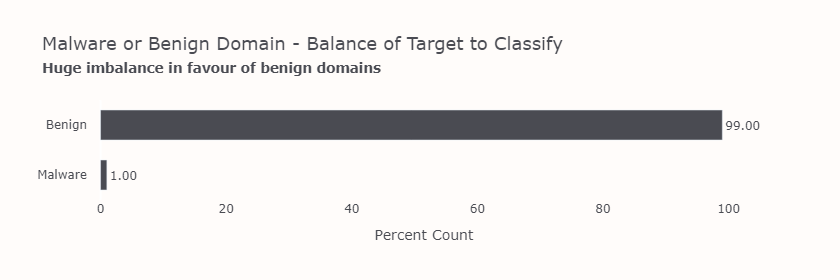

In [8]:
benign_size = len(benign_data)
malware_size = len(malware_data)
total_size = benign_size + malware_size

fig = px.bar(
    x=[benign_size / total_size * 100, malware_size / total_size * 100],
    y=["Benign", "Malware"],
    text_auto=".2f",  # type: ignore
    title="Malware or Benign Domain - Balance of Target to Classify<br>"
    "<span style='font-size: 75%; font-weight: bold;'>"
    "Huge imbalance in favour of benign domains</span>",
    color_discrete_sequence=["#4A4B52"],
    height=280,
    width=840,
)
fig.update_xaxes(title="Percent Count", range=(-2, 105))
fig.update_yaxes(title="", categoryorder="total ascending")
fig.update_traces(textposition="outside")
fig.update_layout(bargap=0.4)
save_and_show_fig(fig, "target_balance")


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #F78A1F;
">
    <b>Dataset Size &amp; Target Imbalance</b>
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    There is a huge imbalance in terms of target, so we have to handle that in some way. <b>Two example solutions are to apply undersampling in terms of prevailing class or attach higher weights to rare class. Another third solution may be oversampling rare class with, for example, SMOTE algorithm. Nevertheless, this way, we can introduce samples that are not enough representative.</b> Now, let's have a look at datasets missing values and diversity.
</p>

In [9]:
print("Benign Dataset Summary:")
get_pretty_frame(missing_unique_vals_summary(benign_data), gradient=True)


Benign Dataset Summary:


,Dtype,MissingValues,MissingValuesRatio,UniqueValues,UniqueValuesRatio,MostFreqValue,MostFreqValueCount,MostFreqValueCountRatio
1gram,object,22,0.000,208752,0.422,-1.0,30829,0.062
2gram,object,187,0.000,226923,0.459,"['go', 'oo', 'og', 'gl', 'le']",1000,0.002
3gram,object,0,0.000,207750,0.420,0,32087,0.065
ASN,float64,108886,0.220,10330,0.021,13335.000,48675,0.099
Alexa_Rank,object,53847,0.109,114087,0.231,-1.0,147128,0.298
Country,object,108941,0.220,284,0.001,US,207300,0.420
Country.1,object,240042,0.486,1614,0.003,US,111890,0.226
Creation_Date_Time,object,131913,0.267,143465,0.290,before Aug-1996,2843,0.006
Domain,object,0,0.000,309838,0.627,b'www.hugedomains.com.',262,0.001
Domain_Age,object,53843,0.109,329765,0.667,0,80609,0.163


In [10]:
print("Malware Dataset Summary:")
get_pretty_frame(missing_unique_vals_summary(malware_data), gradient=True)


Malware Dataset Summary:


,Dtype,MissingValues,MissingValuesRatio,UniqueValues,UniqueValuesRatio,MostFreqValue,MostFreqValueCount,MostFreqValueCountRatio
1gram,object,0,0.000,3139,0.628,"['h', 'u', 'g', 'e', 'd', 'o', 'm', 'a', 'i', 'n', 's']",240,0.048
2gram,object,0,0.000,3139,0.628,"['hu', 'ug', 'ge', 'ed', 'do', 'om', 'ma', 'ai', 'in', 'ns']",240,0.048
3gram,object,0,0.000,3123,0.625,"['hug', 'uge', 'ged', 'edo', 'dom', 'oma', 'mai', 'ain', 'ins']",240,0.048
ASN,float64,944,0.189,559,0.112,26496.000,275,0.055
Alexa_Rank,float64,571,0.114,202,0.040,-1.000,3708,0.742
Country,object,946,0.189,81,0.016,US,2125,0.425
Country.1,object,2109,0.422,103,0.021,US,1364,0.273
Creation_Date_Time,object,1175,0.235,2351,0.470,2003-10-31 19:24:33,232,0.046
Domain,object,0,0.000,3739,0.748,b'www.hugedomains.com.',240,0.048
Domain_Age,object,571,0.114,3826,0.765,0,604,0.121


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #F78A1F;
">
    <b>Missing Values &amp; Diversity</b>
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    What catches the eye is the many missing values in both datasets. At this stage, we can probably reject some features with a high ratio of missing values. These are: Country.1, Organization, Registrant_Name and State. The other solution is to introduce a missing category since these features seem to be categorical.<br><br> 
    Now let's have a look at some more interesting features closely. 
</p>

<ul style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    <li>Alexa_Rank - This feature means the rank of the domain by Alexa. The most interesting thing here is quite a big disproportion between benign data and malware data, i.e. 30% of the feature in benign is -1, whereas in malware, it's 74%. I asked ChatGPT what it means that Alexa's value is -1, and he said that Alexa has not collected sufficient data to assign a rank to that website, so it could be a new website, or a very low-traffic website. Such a disproportion should be informative for machine learning algorithms, I think.</li>
    <li>Creation_Date_Time - The date and time the domain was created. The malware dataset has a higher ratio of unique values, which could mean suspicious domains are created more often. It should be informative also.</li>
    <li>Domain, Domain_Age, Domain_Name, IP, char_distribution, sld - Similarly as in the Creation_Date_Time. The malware dataset has a higher diversity of values in these features.</li>
    <li>dec_32, dec_8, hex_32, hex_8, oc_32, oc_8, obfuscate_at_sign, puny_coded, shortened - These features are characterised by a high ratio (near to 0.9 - 1.0) of the same value. Furthermore in malware data these ratios are almost always equal to one. For such massive disproportion, these features probably won't be informative in detecting malware domains.</li>
</ul>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    <b>So, now we have a little recognition about the data we will be working with. Therefore, it's a good time to split the dataset into training and test subsets.</b>
</p>

## <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">1.2</span> <span style='color: #F78A1F'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Put Down Test Subset</span></b><a class="anchor" id="put_down_test_subset"></a> [↑](#top)

In [11]:
# Assign labels to datasets. Malware will be a positive class.
benign_data["Class"] = 0
malware_data["Class"] = 1

# Index is not important here.
domain_dataset = pd.concat([benign_data, malware_data], ignore_index=True)
domain_data = domain_dataset.drop("Class", axis=1)
domain_target = domain_dataset.Class

X, X_test, y, y_test = train_test_split(
    domain_data,
    domain_target,
    test_size=0.1,  # -> [49414, 500]
    random_state=42,
    shuffle=True,
    stratify=domain_target,
)


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #F78A1F;
">
    <b>Train - Test Split</b>
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    <b>Here, we split the data in a stratified fashion since the dataset is highly imbalanced.</b> This way, we ensure that training and test subsets have the same ratio of negative and positive classes, where the ratio is 99:1. In this case we allocate 10% of the whole dataset to test subset and since now, we don't looking at it. Thus, test subset simulate a future situation, where we feed production data into the final trained model and want to get predictions. Now we can get to exploring, cleaning and writing preprocessing tools looking only at training data. 
</p>

# <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">2</span> <span style='color: #F78A1F'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Quick Analysis of Training Data</span></b><a class="anchor" id="quick_analysis_of_training_data"></a> [↑](#top)

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #F78A1F;
">
    <b>About Section</b>
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    In this section, we will investigate training data more closely. We will build custom preprocessing functions if required and the final preprocessing pipeline using scikit-learn library.
</p>

## <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">2.1</span> <span style='color: #F78A1F'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Closer Look at Features</span></b><a class="anchor" id="closer_look_at_features"></a> [↑](#top)


<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    Generally, at this project stage, we could see global summaries with numerical and categorical features. For example, these summaries can be correlation matrix and hierarchical clustering. These two tools may, for example, assess whether the PCA or some other dimensionality reduction algorithm will come in handy in a specific problem. Another visualisation could be histograms or KDE plots to see outlier values or probability plots to assess whether given variables follow a given distribution, for example, the normal one. Some machine learning algorithms assume that variables follow the normal distribution and may get a performance boost if the condition is met. For example SVM is one of such a model.<br><br>
    <b>However, our dataset is a little messy, so firstly, we need to investigate problems there and restore appropriate data types.</b> Thus, we will analyse each feature step by step, wondering what could be done there and present some visualisations if needed.
</p>

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #F78A1F;
">
    <b>ASN Feature</b>
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    ASN is numeric by default, and it's characterized by a long tail. Therefore, we can transform it with log-level transformation to reduce this effect. Moreover it contains missing values. Preprocessing may be: median imputation, log-level transformation, standarization.
</p>

In [12]:
X.ASN.head()


34566     12389.0
371707     8560.0
446736    13335.0
217045    62082.0
231126    37589.0
Name: ASN, dtype: float64

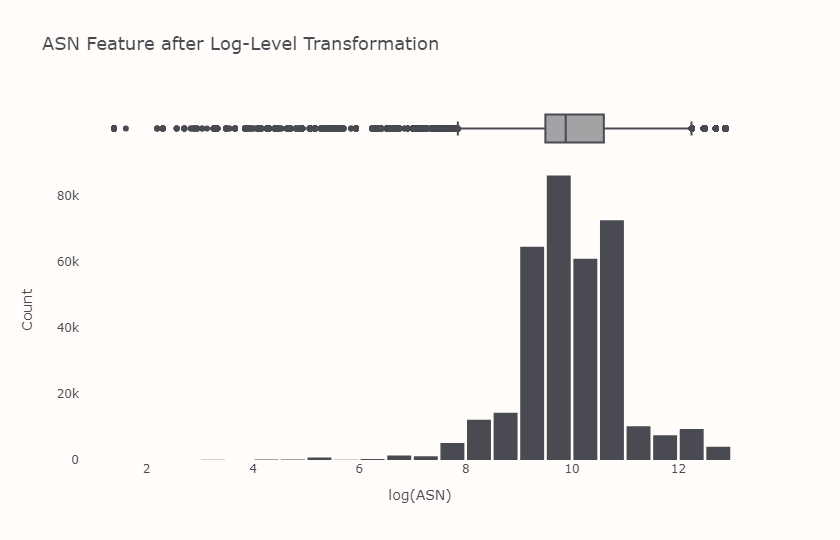

In [13]:
fig = px.histogram(
    x=np.log1p(X.ASN),
    nbins=50,
    color_discrete_sequence=["#4A4B52"],
    title="ASN Feature after Log-Level Transformation",
    marginal="box",
)
fig.update_layout(bargap=0.1)
fig.update_xaxes(title="log(ASN)", row=1)
fig.update_yaxes(title="Count", row=1)
save_and_show_fig(fig, "asn_after_log")


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #F78A1F;
">
    <b>Alexa_Rank Feature</b>
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    Alexa_Rank is characterized by big disproportion between benign and malware data, as we said earlier. Moreover, it contains some typos (string values that are not numerical) and missing values. We can encode this feature as three categories, when it is -1 (not observed by Alexa), when it's more than -1 (when there is a traffic or it's known by Alexa), and when it's missing. It should be fair.<br><br>
    I suppose there are more features such as Alexa_Rank, so here we can write a function that restore numeric type and clean the feature (by introducing NaN values). Function as below can be subsequently included in scikit-learn pipeline and passed to given dataset subset. We will write a custom encoder class for features like Alexa_Rank. We will provide that at the end of this section.
</p>

In [14]:
# The backslash provides that we have to pass arguments before it only as positional ones.
def restore_numeric_dtypes(X, /):
    # Some values in certain features may have typos or mismatched types,
    # so errors="coerce" option will replace such things with NaN. For example,
    # when the column should be numerical by default but contains typo like
    # "1.0abc", it will be replaced as NaN.
    return X.apply(pd.to_numeric, errors="coerce")


In [15]:
X.Alexa_Rank.head()


34566      313137.0
371707         -1.0
446736    2177921.0
217045         -1.0
231126         -1.0
Name: Alexa_Rank, dtype: object

In [16]:
X.Alexa_Rank.value_counts()[:3]


Alexa_Rank
-1.0      132172
-1.0        3321
2384.0       205
Name: count, dtype: int64

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #F78A1F;
">
    <b>Country Feature</b>
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    In the Country the situation is very similar to the Alexa_Rank feature. Here, we have quite a lot of missing values, and the variable is dominated by the US code. Again, initially, we can preprocess this by introducing three categories, US, missing, and other. 
</p>

In [17]:
X.Country.head()


34566     RU
371707    US
446736    US
217045    RU
231126    ZA
Name: Country, dtype: object

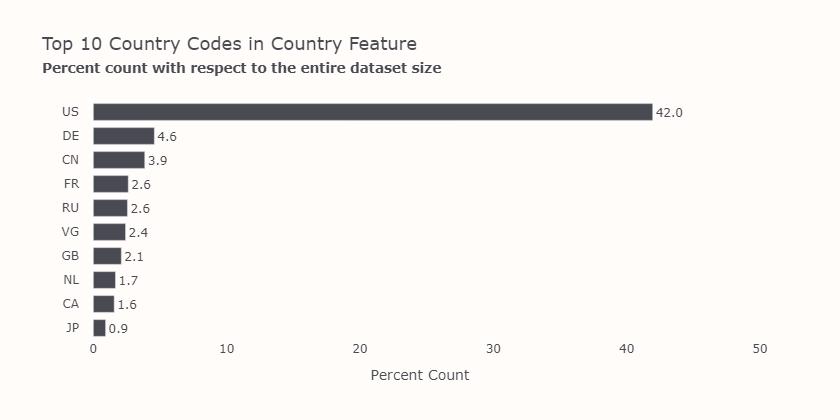

In [18]:
top_countries = X.groupby("Country").size().sort_values(ascending=False).head(10) / len(X) * 100
fig = px.bar(
    x=top_countries.values,
    y=top_countries.index,
    text_auto=".1f",
    color_discrete_sequence=["#4A4B52"],
    title="Top 10 Country Codes in Country Feature<br>"
    "<span style='font-size: 75%; font-weight: bold;'>"
    "Percent count with respect to the entire dataset size",
)
fig.update_layout(bargap=0.3, height=420)
fig.update_traces(textposition="outside")
fig.update_xaxes(title="Percent Count", range=(-1, 50))
fig.update_yaxes(title="", categoryorder="total ascending")
save_and_show_fig(fig, "top_country_codes")


In [19]:
# What is it?
X.Country.sort_values(ascending=False, key=lambda x: x.str.len())[:5]


116071    133119
266056    397215
176059    205184
55880     139640
99832     139640
Name: Country, dtype: object

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #F78A1F;
">
    <b>Creation_Date_Time Feature</b>
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    Creation_Date_Time is the date and time the domain was created. <b>This feature is more interesting than others, because can tell us about how trend of malware domains evolves over time.</b> Let's see.
</p>

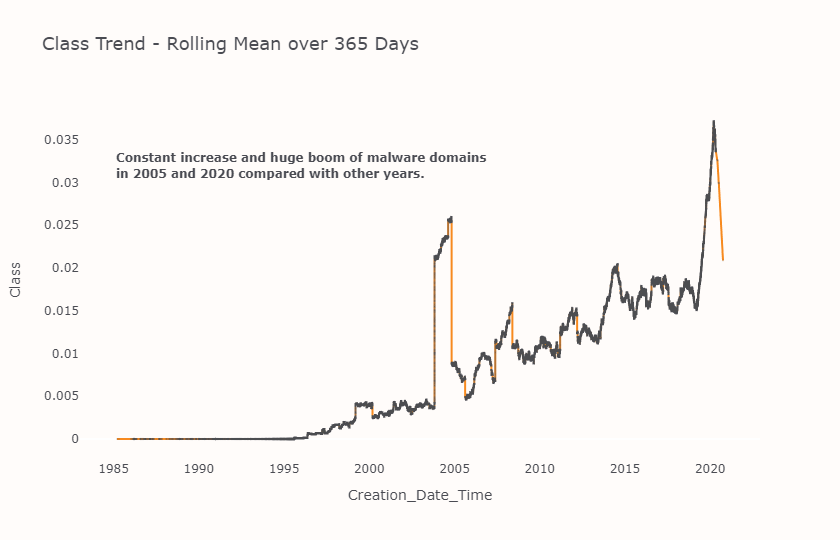

In [20]:
# Future warning related to plotly plot. It's not so important.
warnings.simplefilter(action="ignore", category=FutureWarning)

rolling_mean_class = (
    X[["Creation_Date_Time"]]
    .assign(Class=y, Creation_Date_Time=pd.to_datetime(X.Creation_Date_Time, errors="coerce"))
    .dropna()
    .sort_values(by="Creation_Date_Time")
    .rolling(window="365D", on="Creation_Date_Time")
    .mean()
)

fig = px.line(
    rolling_mean_class,
    x="Creation_Date_Time",
    y="Class",
    height=540,
    width=840,
    color_discrete_sequence=["#F78A1F"],
    symbol_sequence=["x"],
    markers=True,
    title="Class Trend - Rolling Mean over 365 Days",
)
fig.add_annotation(
    x="1985-01-01",
    y=0.032,
    align="left",
    xanchor="left",
    text="<b>Constant increase and huge boom of malware domains<br>"
    "in 2005 and 2020 compared with other years.<br>",
    showarrow=False,
)
fig.update_traces(marker=dict(size=2, color="#4A4B52", opacity=0.2))
save_and_show_fig(fig, "class_trend_over_time")


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #F78A1F;
">
    <b>Malware Attacks over Time</b>
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    As you can see, there were no malware domains before 1995 or observations related to them don't have Creation_Date_Time. On the other hand, we observe a constant increase in malware domains created after 1995, with two booms in 2005 and 2020. We could use this information, for example, by attaching higher weights to samples with more recent Creation_Date_Time values. On the other hand, this feature in itself should be very informative for machine learning algorithms.<br><br>
    Now let's write a function that preprocesses this feature into numeric value.
</p>

In [21]:
def creation_date_time_to_numeric(X, /):
    creation_date_time = (
        pd.to_datetime(
            # "1996-07-01 00:00:00" is subjective.
            X.iloc[:, 0].replace("before Aug-1996", "1996-07-01 00:00:00"),
            errors="coerce",  # If something is wrong, then treat as NaT.
        )
        .astype(np.int64)
        .astype(np.float64)
    )
    # Converting NaT to float introduces negative values.
    # Therefore mask it with NaN and return as frame, since scikit-learn
    # requires 2D input, even if there is one feature.
    return creation_date_time.mask(creation_date_time < 0).to_frame()


In [22]:
X.Creation_Date_Time.head()


34566     1999-05-28 13:37:35
371707    2015-09-13 12:11:06
446736    2010-08-22 14:42:49
217045    2010-09-17 01:33:46
231126                    NaN
Name: Creation_Date_Time, dtype: object

In [23]:
creation_date_time_to_numeric(X[["Creation_Date_Time"]]).head()


,Creation_Date_Time
34566,9.278987e+17
371707,1.442146e+18
446736,1.282488e+18
217045,1.284687e+18
231126,NaN


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #F78A1F;
">
    <b>Domain &amp; Domain_Name Features</b>
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    Domain and Domain_Name - These feature are very similar to each other. The main difference is that Domain contains one value, i.e. main website domain. On the other hand Domain_Name can contain multiple or dozens of names of the domain, for example, ['CCALTINBAS.COM', 'CcAltinBas.com']. Therefore, as for now, we can use only one of them to feed the machine learning algorithm. Moreover tld feature describes top level domain, for example, "com", so here is no need to retrieve such information. On the other hand, there are too many categories in terms of encoding. So what to do with this? I think we can utilise this feature to calculate its length. But the length of domain or subdomain is available in the dataset under len feature, so it seems that we can abandon Domain variable. 
</p>

In [24]:
# Retrieve only domain without www and b''.
X.Domain.str.strip("wb'.").head()  # .map(len)


34566                 nsk.su
371707      stephwenburg.com
446736    movienewsguide.com
217045           neomagia.ru
231126     d9credemo33.co.za
Name: Domain, dtype: object

In [25]:
X.Domain.str.strip("wb'.").head().map(len, na_action="ignore")


34566      6
371707    16
446736    18
217045    11
231126    17
Name: Domain, dtype: int64

In [26]:
# Let's see what is the longest domain_name and what it contains.
X.Domain_Name.str.strip("b'.").sort_values(ascending=False, key=lambda x: x.str.len()).iloc[0]


"['SEAEMBU.ORG', 'seaembu.org<br>Registry Domain ID: <br>Registrar WHOIS Server: whois.onlinenic.com<br>Registrar URL: http://www.onlinenic.com<br>Updated Date: 2020-02-27T09:35:27Z<br>Creation Date: 2004-05-26T04:00:00Z<br>Registrar Registration Expiration Date: 2020-05-26T04:00:00Z<br>Registrar: Onlinenic Inc<br>Registrar IANA ID: 82<br>Registrar Abuse Contact Email: abuse@onlinenic.com<br>Registrar Abuse Contact Phone: +1.5107698492<br>Domain Status: ok<br>Registry Registration ID: <br>Registration Name: Joao Victor Goncalves Franco<br>Registration Organization: sociedade ecologica amigos de embu<br>Registration Street: av. joao batista medina 358<br>Registration City: embu<br>Registration State/Province: sao paulo<br>Registration Postal Code: 06840030<br>Registration Country: BR<br>Registration Phone: +55.1147816837<br>Registration Phone Ext:<br>Registration Fax: +55.1147816837<br>Registration Fax Ext:<br>Registration Email: financeiro@turbosite.com.br<br>Registry Registration ID: 

In [27]:
X.Domain_Name.head()


34566                                       NSK.SU
371707    ['STEPHWENBURG.COM', 'stephwenburg.com']
446736                          MOVIENEWSGUIDE.COM
217045                                 NEOMAGIA.RU
231126                                         NaN
Name: Domain_Name, dtype: object

In [28]:
X.Domain_Name.str.split(" ", expand=True).iloc[:, 0].str.strip("[]b'.,").head()


34566                 NSK.SU
371707      STEPHWENBURG.COM
446736    MOVIENEWSGUIDE.COM
217045           NEOMAGIA.RU
231126                   NaN
Name: 0, dtype: object

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #F78A1F;
">
    <b>Domain_Age Feature</b>
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    Domain_Age means the age of the domain. We can retrieve age in days and include in machine learning input matrix as normalized values. For this we will write retrieve_days_from_domain_age() function. See below.
</p>

In [29]:
X.Domain_Age.head(5)


34566     7636 days 18:38:48.749528
371707    1690 days 12:59:56.192693
446736    3539 days 14:46:22.015488
217045    3510 days 11:05:01.575068
231126                            0
Name: Domain_Age, dtype: object

In [30]:
def retrieve_days_from_domain_age(X, /):
    age_frame = X.Domain_Age.str.split(" ", expand=True).rename(
        # Expand returns data frame with default column names, i.e. 0, 1, 2.
        columns={0: "Domain_Age_Days", 1: "Period", 2: "Hours"}
    )
    return pd.to_numeric(age_frame.Domain_Age_Days, errors="coerce").to_frame()


In [31]:
retrieve_days_from_domain_age(X[["Domain_Age"]]).head()


,Domain_Age_Days
34566,7636.0
371707,1690.0
446736,3539.0
217045,3510.0
231126,0.0


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #F78A1F;
">
    <b>Emails Feature</b>
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    Emails - The emails associated to a domain. Here we can utilise the previous idea with the length of domain, but for emails. Emails has a lot of missing values, but if we want to treat this feature in terms of numerical values, then we can fill missing one with empty string. Then when we map it to length, zero will be mean that there aren't any emails. 
</p>

In [32]:
def map_word_to_len(X, /, fill_value=""):
    return X.iloc[:, [0]].fillna(fill_value).astype(str).map(len)


In [33]:
X.Emails.head()


34566                                          abon@risp.ru
371707    ['abuse@ionos.com', 'dataprivacyprotected@1und...
446736                                    abuse@godaddy.com
217045                                                  NaN
231126                                                  NaN
Name: Emails, dtype: object

In [34]:
map_word_to_len(X[["Emails"]]).head()


,Emails
34566,12
371707,52
446736,17
217045,0
231126,0


In [35]:
# Longest emails observation.
X.Emails.sort_values(ascending=False, key=lambda x: x.str.len()).iloc[0]


"['abuse@key-systems.net', 'abusereport@key-systems.net', '7c53b33cbdd3eb315de2c8766a8ad65ad456780f9ba3ffbfe58b49347af57878@carsdream.com.whoisproxy.org', '7c53b33cbdd3eb315de2c8766a8ad65a3a110feeab6b6aeb830d0fad752003c3@carsdream.com.whoisproxy.org', '7c53b33cbdd3eb315de2c8766a8ad65a33fa68509529cf11d8e78519322a7217@carsdream.com.whoisproxy.org', '7c53b33cbdd3eb315de2c8766a8ad65ae686f6d90eebb7a1d33c28731c184022@carsdream.com.whoisproxy.org']"

In [36]:
# Extract emails from list of emails.
X.Emails.str.replace("[\[\],']", "", regex=True).head()


34566                                      abon@risp.ru
371707    abuse@ionos.com dataprivacyprotected@1und1.de
446736                                abuse@godaddy.com
217045                                              NaN
231126                                              NaN
Name: Emails, dtype: object

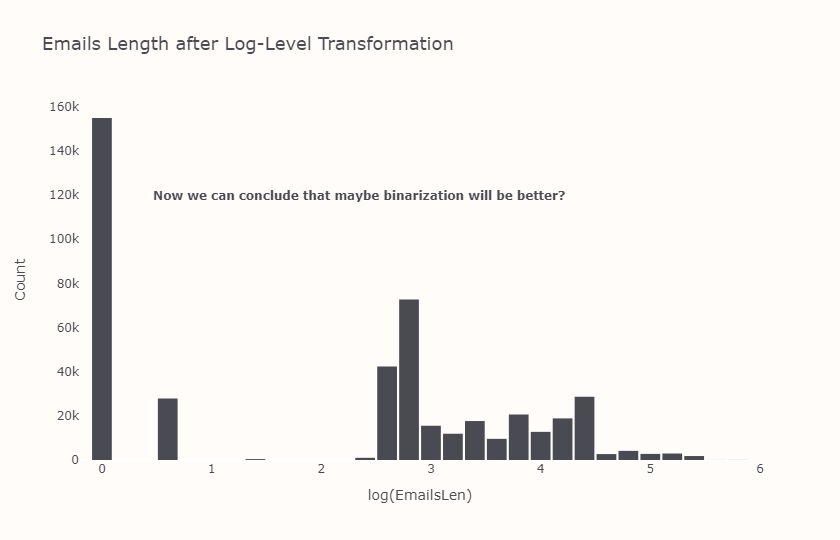

In [37]:
emails_len_log = np.log1p(X.Emails.str.replace("[\[\],']", "", regex=True).fillna("").map(len))

fig = px.histogram(
    x=emails_len_log,
    nbins=50,
    color_discrete_sequence=["#4A4B52"],
    title="Emails Length after Log-Level Transformation",
)
fig.add_annotation(
    x=0.45,
    y=120_000,
    align="left",
    xanchor="left",
    text="<b>Now we can conclude that maybe binarization will be better?",
    showarrow=False,
)
fig.update_layout(bargap=0.1)
fig.update_xaxes(title="log(EmailsLen)", range=(-0.2, 6))
fig.update_yaxes(title="Count", row=1)
save_and_show_fig(fig, "emails_len_after_log")


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #F78A1F;
">
    <b>Name_Server_Count Feature</b>
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    Name_Server_Count - The total number of name servers linked to the domain. This feature has an enormous standard deviation. This is probably related to the situation when there are only one or several emails related to a person who holds the domain and billions of emails where the domain belongs to Google, Facebook or some other big company. So the first idea may be to discretize this feature with a threshold of several emails, for example 4.
</p>

In [38]:
X.Name_Server_Count.head()


34566     2.0
371707    4.0
446736    2.0
217045    2.0
231126    0.0
Name: Name_Server_Count, dtype: object

In [39]:
server_count = restore_numeric_dtypes(X[["Name_Server_Count"]])
server_count.Name_Server_Count.sort_values(ascending=False)[:15]


367011    5.000000e+58
213366    1.340876e+10
213365    1.340876e+10
100045    4.008876e+09
451464    4.008000e+09
451465    4.008000e+09
93512     4.007031e+09
362248    4.006123e+09
362247    4.006123e+09
132347    4.001662e+09
207532    9.997777e+08
335680    4.089889e+08
98277     9.988444e+07
98278     9.988444e+07
98279     9.988444e+07
Name: Name_Server_Count, dtype: float64

In [40]:
server_count.describe(percentiles=[0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99]).T


,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
Name_Server_Count,310848.0,1.608503e+53,8.968008e+55,-1.0,0.0,0.0,2.0,2.0,4.0,12.0,24.0,5.000000e+58


In [41]:
name_server_count_preprocess = make_pipeline(
    FunctionTransformer(restore_numeric_dtypes, feature_names_out="one-to-one"),
    SimpleImputer(strategy="median"),
    Binarizer(threshold=4),
)

out = name_server_count_preprocess.fit_transform(X[["Name_Server_Count"]])
pd.Series(out.flatten()).value_counts()


0.0    393262
1.0     55958
Name: count, dtype: int64

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #F78A1F;
">
    <b>Organization Feature</b>
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    Organization - What organization it is linked to. Here we have a lot of missing values, i.e. around 60%. Therefore introducing a missing category seems to be logical. In this way we can binarize this feature again, when there is an observation of a company and not.
</p>

In [42]:
X.Organization.value_counts().head()


Organization
REDACTED FOR PRIVACY       21629
Domains By Proxy           17822
WhoisGuard inc.             8591
See PrivacyGuardian.org     3493
Whois Privacy Service       2771
Name: count, dtype: int64

In [43]:
X.Organization.head()


34566     Joint Stock Company Rinet
371707               SW Freelancing
446736         Tune Media Pty. Ltd.
217045                          NaN
231126                          NaN
Name: Organization, dtype: object

In [44]:
organization_encoder = OrdinalEncoder(
    handle_unknown="use_encoded_value",
    unknown_value=-1,
    max_categories=1,  # Only one category because we encode all existing observations as 0.
    encoded_missing_value=1,  # Encode NaNs as 1.
)
organization_encoder.fit_transform(X[["Organization"]])[:5]


array([[0.],
       [0.],
       [0.],
       [1.],
       [1.]])

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #F78A1F;
">
    <b>Registrar Feature</b>
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    Registrar - Registrar of the domain. We will encode top 5 most popular registrars and reserve one category for the others.
</p>

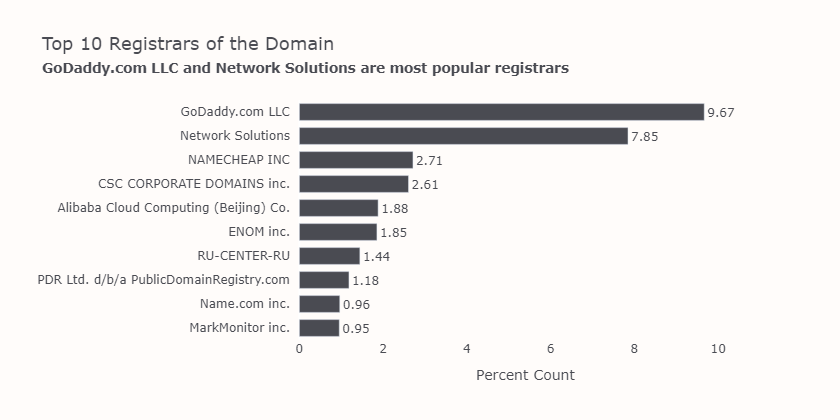

In [45]:
top_registrar = X.groupby("Registrar").size().sort_values(ascending=False).head(10) / len(X) * 100
fig = px.bar(
    x=top_registrar.values,
    y=top_registrar.index,
    color_discrete_sequence=["#4A4B52"],
    text_auto=".2f",
    title="Top 10 Registrars of the Domain<br>"
    "<span style='font-size: 75%; font-weight: bold;'>"
    "GoDaddy.com LLC and Network Solutions are most popular registrars</span>",
)
fig.update_layout(bargap=0.3, height=420)
fig.update_traces(textposition="outside")
fig.update_xaxes(title="Percent Count", range=(-0.2, 11))
fig.update_yaxes(title="", categoryorder="total ascending")
save_and_show_fig(fig, "top_registrars")


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #F78A1F;
">
    <b>State Feature</b>
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    State - The state the main branch is. Similarly as for registrars, we will encode top 5 most popular states and reserve one category for the others. Since registrar and state are categorical and there is enough missing values to create separate category for NaNs.
</p>

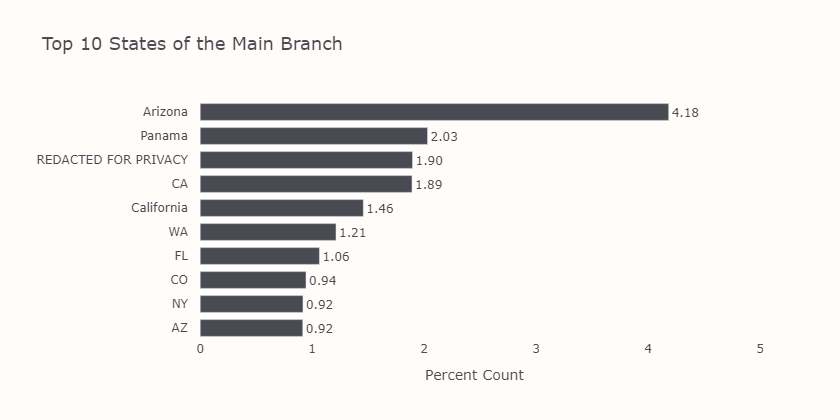

In [46]:
top_states = X.groupby("State").size().sort_values(ascending=False).head(10) / len(X) * 100
fig = px.bar(
    x=top_states.values,
    y=top_states.index,
    color_discrete_sequence=["#4A4B52"],
    text_auto=".2f",
    title="Top 10 States of the Main Branch",
)
fig.update_layout(bargap=0.3, height=420)
fig.update_traces(textposition="outside")
fig.update_xaxes(title="Percent Count", range=(-0.1, 5))
fig.update_yaxes(title="", categoryorder="total ascending")
save_and_show_fig(fig, "top_states")


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #F78A1F;
">
    <b>TTL Feature</b>
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    TTL - The average of TTL or variance of TTL in window t. Hard to say because here is only one feature, but dataset description says about mean and variance of that. This feature has mismatched types and several outlier values. We can clip it to the subjective upper bound and then transform it with logarithm to reduce skewness. Moreover there is no missing values.
</p>

In [47]:
ttl = restore_numeric_dtypes(X[["TTL"]])
ttl.TTL.sort_values(ascending=False).head()


495373    397224.0
495374    397224.0
46036      21599.0
160958     21599.0
246963     21599.0
Name: TTL, dtype: float64

In [48]:
def clip_numeric_feature(X, /, lower_bound=None, upper_bound=None):
    return np.clip(X.iloc[:, [0]], lower_bound, upper_bound)


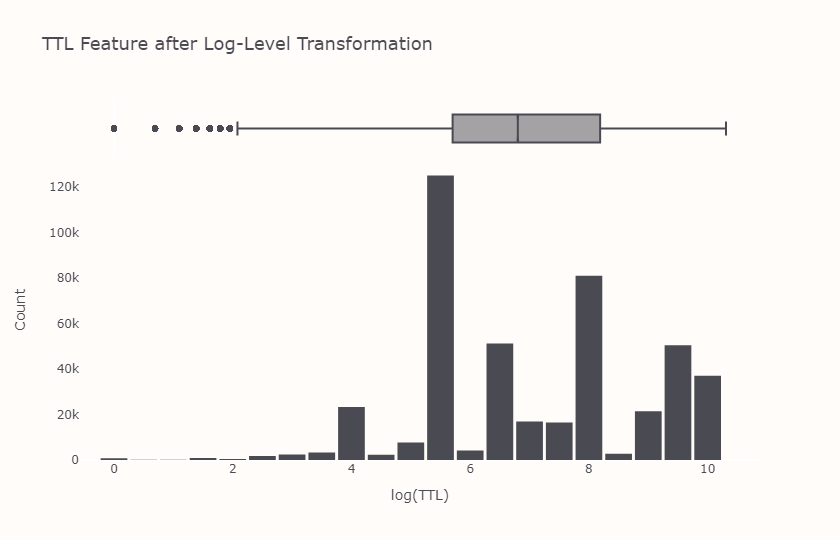

In [49]:
ttl_clipped_and_log = np.log1p(clip_numeric_feature(ttl, 0, 30_000).TTL)

fig = px.histogram(
    x=ttl_clipped_and_log,
    nbins=40,
    color_discrete_sequence=["#4A4B52"],
    title="TTL Feature after Log-Level Transformation",
    marginal="box",
)
fig.update_layout(bargap=0.1)
fig.update_xaxes(title="log(TTL)", row=1)
fig.update_yaxes(title="Count", row=1)
save_and_show_fig(fig, "ttl_after_log")


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #F78A1F;
">
    <b>Len &amp; Entropy Features</b>
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    Len - Length of domain and subdomain. Here the situation is straightforward. We restore numeric type and fill missing values with the median one. Since there isn't many NaNs such a procedure shouldn't influence the distribution. Subsequently we transform it with log-level transformation in order to reduce long tail and finally standardize it. There are rare situation where this feature is "-1", so we can write a little function to map negative values to zeros.<br><br>
    Entropy - This feature is based on the letter distribution and Shannon's entropy formula. Generally we proceed here the same way as for len but without log-level transformation, since the variable quite well follows the normal distribution. See below.

</p>

In [50]:
def replace_negative_values(X, /, new_value=0):
    return np.where(X.iloc[:, [0]] >= 0, X.iloc[:, [0]], new_value)


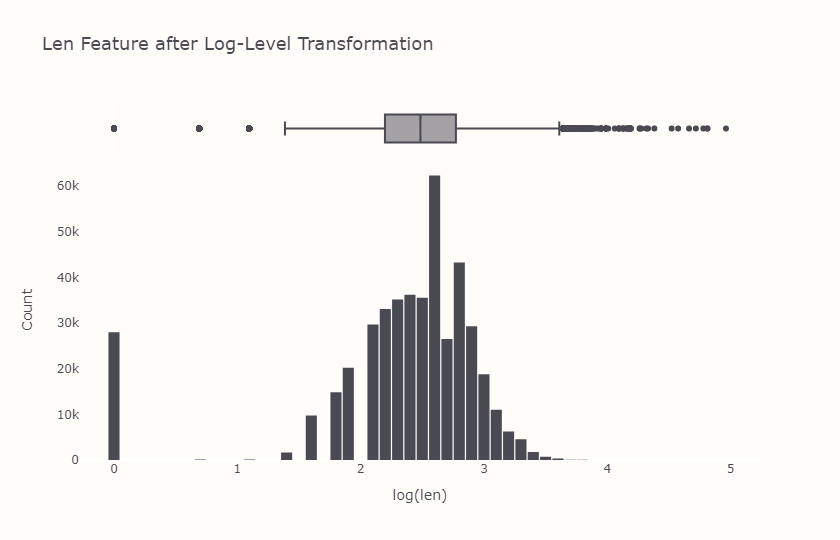

In [51]:
len_feature = restore_numeric_dtypes(X[["len"]])
len_feature_log = np.log1p(replace_negative_values(len_feature).flatten())

fig = px.histogram(
    x=len_feature_log,
    nbins=50,
    color_discrete_sequence=["#4A4B52"],
    title="Len Feature after Log-Level Transformation",
    marginal="box",
)
fig.update_layout(bargap=0.1)
fig.update_xaxes(title="log(len)", row=1)
fig.update_yaxes(title="Count", row=1)
save_and_show_fig(fig, "len_after_log")


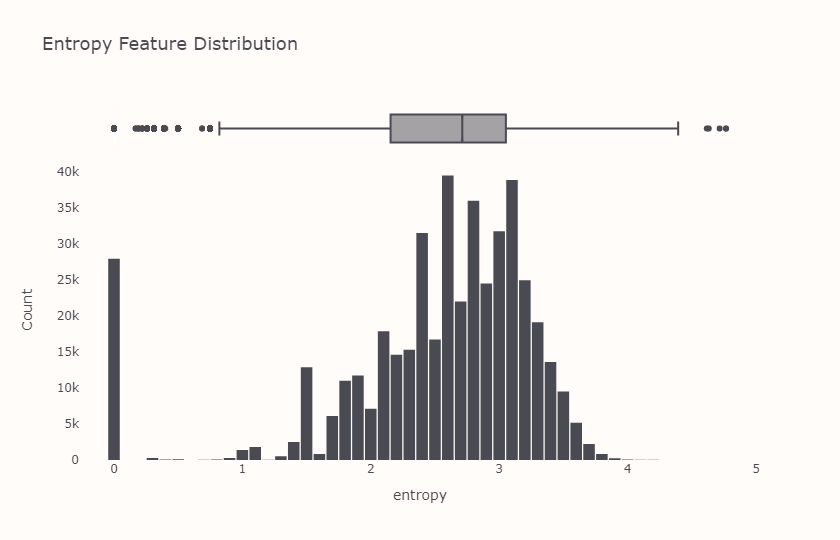

In [52]:
entropy_feature = restore_numeric_dtypes(X[["entropy"]]).entropy

fig = px.histogram(
    x=entropy_feature,
    nbins=50,
    color_discrete_sequence=["#4A4B52"],
    title="Entropy Feature Distribution",
    marginal="box",
)
fig.update_layout(bargap=0.1)
fig.update_xaxes(title="entropy", row=1)
fig.update_yaxes(title="Count", row=1)
save_and_show_fig(fig, "entropy")


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #F78A1F;
">
    <b>Longest_Word Feature</b>
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    Longest_Word - Longest meaningful word in SLD. We will fill missing values with empty string and map the feature to char length.
</p>

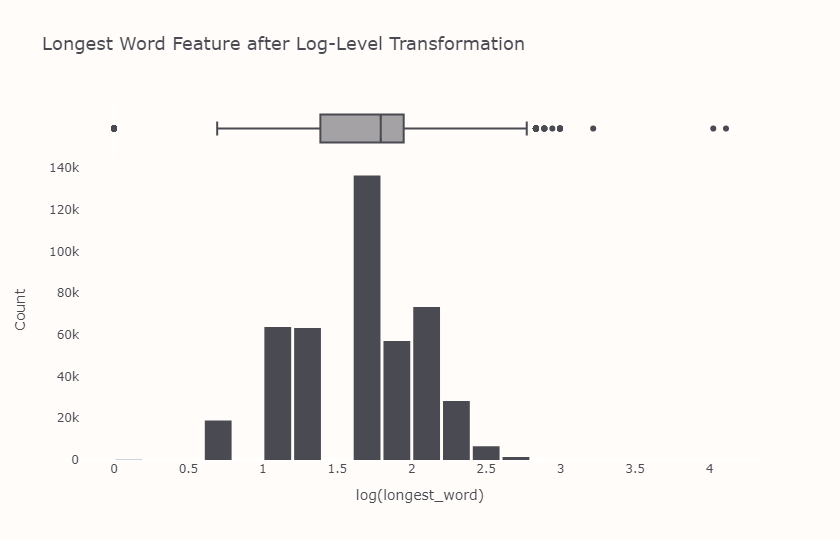

In [53]:
longest_word_log = np.log1p(map_word_to_len(X[["longest_word"]]).longest_word)

fig = px.histogram(
    x=longest_word_log,
    nbins=40,
    color_discrete_sequence=["#4A4B52"],
    title="Longest Word Feature after Log-Level Transformation",
    marginal="box",
)
fig.update_layout(bargap=0.1)
fig.update_xaxes(title="log(longest_word)", row=1)
fig.update_yaxes(title="Count", row=1)
save_and_show_fig(fig, "longest_word_after_log")


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #F78A1F;
">
    <b>SLD Feature</b>
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    SLD - Second-level domain. We can retrieve safest second-level domains and binarize the result as below.
</p>

In [54]:
def encode_sld_with_safe_subdomain(X, /):
    return (
        X.iloc[:, 0]
        .str.strip(" .")
        .str.lower()
        .isin(("llc", "godaddy.com llc", "ltd", "inc"))  # Provides NaN filling.
        .astype(np.uint8)
    ).to_frame()


In [55]:
X.sld.str.strip(" .").str.lower().value_counts(ascending=False).head()


sld
llc                                        45303
godaddy.com llc                            20642
ltd                                        11182
inc                                         2135
pdr ltd. d/b/a publicdomainregistry.com     1597
Name: count, dtype: int64

In [56]:
encode_sld_with_safe_subdomain(X[["sld"]]).value_counts()


sld
0      369958
1       79262
Name: count, dtype: int64

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #F78A1F;
">
    <b>Subdomain Feature</b>
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    Subdomain - Has sub-domain or not. Again we binarize this feature, but the situation is less pleasant because types are mismatched.  
</p>

In [57]:
X.subdomain.value_counts(ascending=False).head(10)


subdomain
0                                                              289293
1                                                              137914
0.0                                                             12016
1.0                                                              5041
0                                                                2762
1                                                                1737
-1.0                                                              116
60416.0                                                             6
1Administracion General de La Comunidad Autonoma de Euskadi         6
Department Cmolenskoy field of information technology               6
Name: count, dtype: int64

In [58]:
X.subdomain.isin((1, "1", "1.0")).astype(np.uint8).value_counts()


subdomain
0    304528
1    144692
Name: count, dtype: int64

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #F78A1F;
">
    <b>TLD Feature</b>
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    TLD - Top-level domain. Here the situation is quite simple. For example we can encode top 5 most frequent TLDs and reserve one code for infrequent values. See bar plot below.

</p>

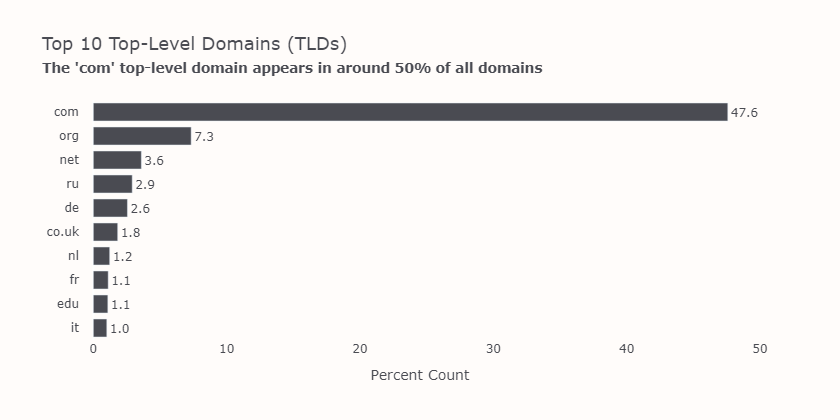

In [59]:
top_level_domains = X.groupby("tld").size().sort_values(ascending=False).head(10) / len(X) * 100
fig = px.bar(
    x=top_level_domains.values,
    y=top_level_domains.index,
    color_discrete_sequence=["#4A4B52"],
    text_auto=".1f",
    title="Top 10 Top-Level Domains (TLDs)<br>"
    "<span style='font-size: 75%; font-weight: bold;'>"
    "The 'com' top-level domain appears in around 50% of all domains</span>",
)
fig.update_layout(bargap=0.25, height=420)
fig.update_traces(textposition="outside")
fig.update_xaxes(title="Percent Count", range=(-1, 50))
fig.update_yaxes(title="", categoryorder="total ascending")
save_and_show_fig(fig, "top_tlds")


In [60]:
# Something that shouldn't be here.
X.tld.sort_values(ascending=False, key=lambda x: x.str.len()).head()


69276     10131 days 19:13:28.869181
353767    11234 days 14:48:28.258088
69277     10131 days 19:13:29.714638
164990    10127 days 11:22:35.079030
353768    11234 days 14:48:29.174272
Name: tld, dtype: object

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #F78A1F;
">
    <b>TLD Encoder</b>
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    We can encode top 5 frequent tlds with OrdinalEncoder as below. We pass interesting categories by hand. In this case top 5 most frequent ones. Moreover categories with a smaller cardinality than min_frequency * n_samples will be considered infrequent.
</p>

In [61]:
X.tld.head()


34566        su
371707      com
446736      com
217045       ru
231126    co.za
Name: tld, dtype: object

In [62]:
tld_encoder = OrdinalEncoder(
    categories=[["com", "org", "net", "ru", "de"]],
    handle_unknown="use_encoded_value",
    unknown_value=-1,
    min_frequency=0.02,  # type: ignore
    max_categories=5,  # type: ignore
)
tld_encoder.fit_transform(X[["tld"]])[:5]


array([[-1.],
       [ 0.],
       [ 0.],
       [ 3.],
       [-1.]])

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #F78A1F;
">
    <b>Summary</b>
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    To summarize, we presented 17 features in a big nutshell and proposed some ideas on what to do with them. What about the others? Well, 21 features have been omitted. The point is that there is no a clear idea of what to do, for example, with n-grams, typos or char distribution. On the other hand, there are features like Country.1, which is probably the same as Country? Some of the features were not taken into account due to the high ratio of the same value. These are, for example, dec, hex, and oc-like variables. So, let's build a pipeline for these 17 ones and see what we can achieve.
</p>

## <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">2.2</span> <span style='color: #F78A1F'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Preprocessing Pipeline</span></b><a class="anchor" id="preprocessing_pipeline"></a> [↑](#top)

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #F78A1F;
">
    <b>Gather Utility Function in One Place</b>
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    Let's recollect all utility functions we wrote in a one place.
</p>

In [63]:
# The backslash provides that we have to pass arguments before it only as positional ones.
def restore_numeric_dtypes(X, /):
    # Some values in certain features may have typos or mismatched types,
    # so errors="coerce" option will replace such things with NaN. For example,
    # when the column should be numerical by default but contains typo like
    # "1.0abc", it will be replaced as NaN.
    return X.apply(pd.to_numeric, errors="coerce")


def creation_date_time_to_numeric(X, /):
    creation_date_time = (
        pd.to_datetime(
            # "1996-07-01 00:00:00" is subjective.
            X.iloc[:, 0].replace("before Aug-1996", "1996-07-01 00:00:00"),
            errors="coerce",  # If something is wrong, then treat as NaT.
        )
        .astype(np.int64)
        .astype(np.float64)
    )
    # Converting NaT to float introduces negative values.
    # Therefore mask it with NaN.
    return creation_date_time.mask(creation_date_time < 0).to_frame()


def retrieve_days_from_domain_age(X, /):
    age_frame = X.Domain_Age.str.split(" ", expand=True).rename(
        # Expand returns data frame with default column names, i.e. 0, 1, 2.
        columns={0: "Domain_Age_Days", 1: "Period", 2: "Hours"}
    )
    return pd.to_numeric(age_frame.Domain_Age_Days, errors="coerce").to_frame()


def map_word_to_len(X, /, fill_value=""):
    return X.iloc[:, [0]].fillna(fill_value).astype(str).map(len)


def clip_numeric_feature(X, /, lower_bound=None, upper_bound=None):
    return np.clip(X.iloc[:, [0]], lower_bound, upper_bound)


def replace_negative_values(X, /, new_value=0):
    return np.where(X.iloc[:, [0]] >= 0, X.iloc[:, [0]], new_value)


def encode_sld_with_safe_subdomain(X, /):
    return (
        X.iloc[:, 0]
        .str.strip(" .")
        .str.lower()
        .isin(("llc", "godaddy.com llc", "ltd", "inc"))  # Also provides NaN filling.
        .astype(np.uint8)
    ).to_frame()


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #F78A1F;
">
    <b>NaNSupportiveEncoder Custom Class</b>
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    The class below is a custom encoder for Alexa_Rank, Country and Subdomain features. Inherits by BaseEstimator and TransformerMixin provides compatibility with scikit-learn pipelines. On the other hand when we inherit by OneToOneFeatureMixin, it gives us get_feature_names_out() method. This estimator only transforms the data since there is no need to calculate something using the training dataset.
</p>

In [64]:
class NaNSupportiveEncoder(BaseEstimator, TransformerMixin, OneToOneFeatureMixin):
    def fit(self, X, y=None):
        self.n_features_in_ = X.shape[1]
        self.feature_names_in_ = np.array(X.columns, dtype=object)
        return self

    def transform(self, X, y=None):
        Xc = X.copy()
        # If NaN -> 0, if (-1.0, "-1", "-1.0") -> 1, if not (-1.0, "-1", "-1.0") -> 2
        alexa_rank_conditions = (  # Conditions order is crucial!
            Xc.Alexa_Rank.isna(),
            Xc.Alexa_Rank.isin((-1, "-1", "-1.0")),
            ~Xc.Alexa_Rank.isin((-1, "-1", "-1.0")),
        )
        alexa_rank_choices = (0, 1, 2)
        Xc.Alexa_Rank = np.select(alexa_rank_conditions, alexa_rank_choices).astype(np.uint8)

        # If NaN -> 0, if "US" -> 1, if not "US" -> 2
        country_conditions = (Xc.Country.isna(), Xc.Country.eq("US"), ~Xc.Country.eq("US"))
        country_choices = (0, 1, 2)
        Xc.Country = np.select(country_conditions, country_choices).astype(np.uint8)

        # Here checking only ones is sufficient because we treat all the others as lack of subdomain.
        Xc.subdomain = Xc.subdomain.isin((1, "1", "1.0")).astype(np.uint8)
        return Xc


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #F78A1F;
">
    <b>Several Transformers</b>
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    Now, let's write several transformers we will be using. Firstly, we wrap FunctionTransformer with partial to include feature_names_out in each transformer we create. Then, we use it to write transformers with functions defined earlier.
</p>

In [65]:
OneToOneFunctionTransformer = partial(FunctionTransformer, feature_names_out="one-to-one")

log1p_transformer = OneToOneFunctionTransformer(np.log1p)
numeric_type_restorer = OneToOneFunctionTransformer(restore_numeric_dtypes)
negative_values_replacer = OneToOneFunctionTransformer(replace_negative_values)
word_to_len_mapper = OneToOneFunctionTransformer(map_word_to_len)
date_time_to_numeric_transformer = OneToOneFunctionTransformer(creation_date_time_to_numeric)

median_imputer = SimpleImputer(strategy="median")
most_frequent_imputer = SimpleImputer(strategy="most_frequent")
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
scaler = StandardScaler()


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #F78A1F;
">
    <b>Feature Preprocessing Pipelines</b>
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    Now we will write preprocessing pipelines for features we were talking earlier. Each preprocessing pipeline starts with a prefix of the feature name. Every step in pipelines should explain itself.
</p>

In [66]:
asn_preprocess = make_pipeline(
    median_imputer,
    log1p_transformer,
    scaler,
)
creation_date_time_preprocess = make_pipeline(
    OneToOneFunctionTransformer(creation_date_time_to_numeric),
    median_imputer,
    min_max_scaler,
)
domain_age_preprocess = make_pipeline(
    OneToOneFunctionTransformer(retrieve_days_from_domain_age),
    negative_values_replacer,  # Some observations have negative age.
    median_imputer,
    min_max_scaler,
)
emails_preprocess = make_pipeline(
    word_to_len_mapper,  # Supports missing values by replacing with empty string - "".
    log1p_transformer,
)
len_preprocess = make_pipeline(
    numeric_type_restorer,  # numeric_type_restorer may introduce missing values.
    negative_values_replacer,
    median_imputer,
    log1p_transformer,
    scaler,
)
entropy_preprocess = make_pipeline(
    numeric_type_restorer,
    median_imputer,
    scaler,
)
longest_word_preprocess = make_pipeline(
    word_to_len_mapper,
    log1p_transformer,
    scaler,
)
# The `encode_sld_with_safe_subdomain()` supports missing values.
sld_preprocess = OneToOneFunctionTransformer(encode_sld_with_safe_subdomain)
tld_preprocess = make_pipeline(
    # There is a little bit of missing values so `most_frequent` (com) will be fine.
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder(
        # Most popular categories in `tld` feature.
        categories=[["com", "org", "net", "ru", "de"]],
        handle_unknown="use_encoded_value",
        unknown_value=-1,
        min_frequency=0.02,  # type: ignore
        max_categories=5,  # type: ignore
    ),
)
state_and_registrar_preprocess = OrdinalEncoder(
    categories=[
        # Most popular categories in `State` feature.
        ["Arizona", "Panama", "REDACTED FOR PRIVACY", "CA", "California"],
        # Most popular categories in `Registrar` feature.
        [
            "GoDaddy.com LLC",
            "Network Solutions",
            "NAMECHEAP INC",
            "CSC CORPORATE DOMAINS inc.",
            "Alibaba Cloud Computing (Beijing) Co.",
        ],
    ],
    handle_unknown="use_encoded_value",
    unknown_value=-1,
    min_frequency=0.01,  # type: ignore
    max_categories=5,  # type: ignore
    # Encode missing values with `5` since there are enough missing ones to create separate category.
    encoded_missing_value=5,
)
organization_preprocess = OrdinalEncoder(
    handle_unknown="use_encoded_value",
    unknown_value=-1,
    # Treat all available observations as one category.
    max_categories=1,  # type: ignore
    # There is enough missing values (~60%) to create a separate category.
    encoded_missing_value=1,
)
name_server_count_preprocess = make_pipeline(
    numeric_type_restorer,
    median_imputer,
    # If there is more than 4 emails associated with a domain, then map it to 1, otherwise 0.
    Binarizer(threshold=4),
)
ttl_preprocess = make_pipeline(
    numeric_type_restorer,
    OneToOneFunctionTransformer(
        clip_numeric_feature,
        # I clip `ttl`` from above, since there are several outliers (300_000 like values)
        # Where the rest is smaller than 30_000.
        kw_args={"lower_bound": 0, "upper_bound": 30_000},
    ),
    median_imputer,
    log1p_transformer,
    scaler,
)


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #F78A1F;
">
    <b>Final Preprocessing Pipeline</b>
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    Now we will blend all together and get the final preprocessing pipeline as below:
</p>

In [67]:
preprocess = make_column_transformer(
    (NaNSupportiveEncoder(), ["Alexa_Rank", "Country", "subdomain"]),
    (asn_preprocess, ["ASN"]),
    (creation_date_time_preprocess, ["Creation_Date_Time"]),
    (domain_age_preprocess, ["Domain_Age"]),
    (emails_preprocess, ["Emails"]),
    (len_preprocess, ["len"]),
    (entropy_preprocess, ["entropy"]),
    (longest_word_preprocess, ["longest_word"]),
    (sld_preprocess, ["sld"]),
    (tld_preprocess, ["tld"]),
    (state_and_registrar_preprocess, ["State", "Registrar"]),
    (organization_preprocess, ["Organization"]),
    (name_server_count_preprocess, ["Name_Server_Count"]),
    (ttl_preprocess, ["TTL"]),
    remainder="drop",  # Remove features that are not listed above.
    verbose_feature_names_out=False,  # Processed data frame has the same feature names as input.
).set_output(transform="pandas")


In [68]:
# Let's see whether it works.
X_processed = preprocess.fit_transform(X)

# Is all appropriate for ML algorithms?
assert np.all(np.isfinite(X_processed)) == True
assert np.any(np.isnan(X_processed)) == False

# It works actually.
X_processed.head()


,Alexa_Rank,Country,subdomain,ASN,Creation_Date_Time,Domain_Age,Emails,len,entropy,longest_word,sld,tld,State,Registrar,Organization,Name_Server_Count,TTL
34566,2,2,0,-0.633910,0.399505,0.595168,2.564949,-1.029376,-1.199186,-0.682740,0,-1.0,-1.0,-1.0,0.0,0.0,0.547375
371707,1,1,0,-1.064100,0.857893,0.131723,3.970292,0.421999,0.926081,-0.167349,0,0.0,-1.0,-1.0,0.0,0.0,0.364096
446736,2,1,0,-0.548288,0.715578,0.275838,2.890372,0.610228,0.846666,0.253756,0,0.0,-1.0,0.0,0.0,0.0,-0.769251
217045,1,2,0,1.241493,0.717538,0.273578,0.000000,-0.052300,0.122199,-0.167349,0,3.0,-1.0,-1.0,1.0,0.0,0.609871
231126,1,2,0,0.657624,0.609511,0.000000,0.000000,0.317535,0.352255,-2.283691,0,-1.0,-1.0,-1.0,1.0,0.0,0.957007


In [69]:
# Let's see how the original data frame looks.
X[preprocess.get_feature_names_out()].head()


,Alexa_Rank,Country,subdomain,ASN,Creation_Date_Time,Domain_Age,Emails,len,entropy,longest_word,sld,tld,State,Registrar,Organization,Name_Server_Count,TTL
34566,313137.0,RU,0,12389.0,1999-05-28 13:37:35,7636 days 18:38:48.749528,abon@risp.ru,4,1.5,nsk,nsk,su,NaN,RUCENTER-SU,Joint Stock Company Rinet,2.0,3386
371707,-1.0,US,0,8560.0,2015-09-13 12:11:06,1690 days 12:59:56.192693,"['abuse@ionos.com', 'dataprivacyprotected@1und...",13,3.261944355207162,burg,stephwenburg,com,NE,1&1 IONOS SE,SW Freelancing,4.0,2416
446736,2177921.0,US,0,13335.0,2010-08-22 14:42:49,3539 days 14:46:22.015488,abuse@godaddy.com,15,3.196105389090386,guide,movienewsguide,com,New South Wales,GoDaddy.com LLC,Tune Media Pty. Ltd.,2.0,299
217045,-1.0,RU,0,62082.0,2010-09-17 01:33:46,3510 days 11:05:01.575068,NaN,9,2.5954888901709436,magi,neomagia,ru,NaN,REGRU-RU,NaN,2.0,3799
231126,-1.0,ZA,0,37589.0,NaN,0,NaN,12,2.78621562566106,3,d9credemo33,co.za,NaN,NaN,NaN,0.0,7199


# <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">3</span> <span style='color: #F78A1F'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Machine Learning Models</span></b><a class="anchor" id="machine_learning_models"></a> [↑](#top)

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #F78A1F;
">
    <b>About Section</b>
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    In this section, we will try to build machine learning model that classify benign and malware domains using 17 features we talked earlier.
</p>

## <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">3.1</span> <span style='color: #F78A1F'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Metrics</span></b><a class="anchor" id="metrics"></a> [↑](#top)

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #F78A1F;
">
    <b>Metrics Comparison</b>
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    Since we have the entire preprocessing pipeline (obviously it's a prototype), we can get to the machine learning. And here the problem arises, i.e. huge imbalance in the target class. There is only 1% of malware observations, but indeed, this class is most important for us. So, it's time to choose which metrics we will be using. In the case of imbalanced datasets, the most popular classification metric, i.e. accuracy is rather out of question. Why? Let's suppose we have 100 samples where 99 are negative and 1 positive. We can say that there is 100 negatives and get 99% of accuracy, brilliant isn't it? Here is the place where metrics, like F1, Recall, Precision and ROC-AUC comes into play. Let's talk about it a little. See the confusion matrix below.
</p>

<ul style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    <center>
        <img src="https://raw.githubusercontent.com/mateuszk098/domain_classifier/master/domain_classification_root/images/confusion_matrix.png" width=500px>
    </center><br>
    <center>
        <b>Confusion Matrix. Source: <a href="https://plat.ai/blog/confusion-matrix-in-machine-learning/">https://plat.ai/blog/confusion-matrix-in-machine-learning</b></a>
    </center>
</ul>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    Here, each column in the confusion matrix represents the actual class, on the other hand each row depicts the predicted class (this is not my favourite form, but I couldn't find better image). Here we need to introduce some indicators:
    <ul style="
        font-size: 16px;
        font-family: 'JetBrains Mono';
    ">
        <li>True Positive (TP) - correctly classified positive class as positive.</li>
        <li>True Negative (TN) - correctly classified negative class as negative.</li>
        <li>False Positive (FP) - incorrectly classified negative class as positive.</li>
        <li>False Negative (FN) - incorrectly classified positive class as negative.</li>
        <li>Precision - accuracy of positive predictions, i.e. $TP\big/(TP + FP)$.</li>
        <li>Recall - true positive rate, i.e. $TP\big/(TP + FN)$.</li>
    </ul>
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    <b>Generally precision says how accurate the model is in the positive class detection, whereas recall says what is the ratio of positive class detected by the model.</b> There is another metric that connects these two, i.e., the F1 score, which is the harmonic mean of precision and recall. It means that F1 is high only when those two metrics are high. However, we don't always want to have these two to be high. For example, when the model has to recognise robbers from camera records, it is better to have high recall and precision may be low. Obviously, there will be some false alarms, but all thieves will be caught.<br><br>
    <b>In our problem, the situation is similar. We want to have high recall and moderately high precision, but the second one can be low. (How much?)</b> Such a trade-off means that malware will always be detected, but the model will make some mistakes during this (will classify benign domain as malware). Nevertheless, it's better to be informed that it may be malware a little too often than actually being attacked.
</p>


## <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">3.2</span> <span style='color: #F78A1F'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Training Strategy</span></b><a class="anchor" id="training_strategy"></a> [↑](#top)

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    Since we know what we want to achieve, here is the moment to get to machine learning. As I said earlier, there are several methods to fight imbalanced datasets. These are undersampling, oversampling and attaching weights to classes. In this notebook, I will try to utilise the first and last solution. Generally, in the undersampling strategy, we want to reduce the number of majority class observations and thus get a more balanced dataset. The problem here is that undersampling eliminates information from the majority class (because we sample only a small percentage of it). Therefore, we usually want to train many different classifiers, where each is trained on a different subset of samples from the majority class. This way, specific models can focus on differences between negative and positive observations, but simultaneously, we provide using most information from the class that prevails. This information is partially included in each classifier. Next, we want to perform voting of all these classifiers.<br><br>
    
</p>

In [70]:
def get_class_weights(y_true, weights=None):
    """Pass `weights` tuple as `(weight_class_0, weight_class_1)`
    if you want to use custom weights."""
    N0, N1 = np.bincount(y_true)
    y0, y1 = np.unique(y_true)

    if weights is not None:
        w0, w1 = weights
        return {y0: w0, y1: w1}

    w0 = (N0 + N1) / N0
    w1 = (N0 + N1) / N1

    return {y0: w0, y1: w1}


In [71]:
def print_classification_stats(y_true, y_proba, threshold=0.5):
    y_pred = np.where(y_proba > threshold, 1, 0)
    print(f"{'F1:':15s}", f"{f1_score(y_true, y_pred):.5f}")
    print(f"{'Recall:':15s}", f"{recall_score(y_true, y_pred):.5f}")
    print(f"{'Specificity:':15s}", f"{recall_score(y_true, y_pred, pos_label=0):.5f}")
    print(f"{'Precision:':15s}", f"{precision_score(y_true, y_pred):.5f}")
    print(f"{'ROC-AUC:':15s}", f"{roc_auc_score(y_true, y_proba):.5f}")
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #F78A1F;
">
    <b>CV Scheme</b>
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    The get_class_weights() function above provides class weights when we undersample the majority class. We can also set our custom weights or use balanced in scikit-learn models. The second function provides a quick summary of the classification. Now, we need to write a cross-validation loop. Firstly, let's set how many undersampling repeats we will be performing in terms of one CV fold. Let's say the n_bags variable is responsible for that. Subsequently, we draw seeds associated with these bags to introduce randomness in each undersampling repeat. Next, we write a CV loop. <b>In this case, we choose StratifiedKFold from the scikit-learn library since there is an imbalance of target, and stratification provides an appropriate ratio of it in training and validation subsets.</b> We also allocate memory for so-called out-of-fold predictions. In the outer CV loop, we split the dataset into training and validation subsets and come under the inner loop. <b>Now, we perform an undersampling strategy with respect to the training subset. Here, it is crucial not to touch validation data! This way, we simulate how the model trained on undersampled data will behave on an unseen and imbalanced test dataset.</b> We repeat this process n_bags times for each fold to gather predictions and extract enough information from the majority class, which is lost due to undersampling.<br><br>
    Moreover, when building a machine learning model, blending several classifiers or regressors is usually a good approach. Such a blend of models is called an ensemble and usually improves the general performance. <b>The point is that several completely different (this is essential, these should be different) algorithms will probably make different types of mistakes.</b> Thanks to this, we allow them to "compete", and then we gather mean probability using their predictions. Here, I will use RandomForestClassifier and KNeighborsClassifier.
</p>

In [72]:
np.random.seed(42)  # Make seeds reproducible.

n_bags = 5  # How many repeats in undersampling strategy.
seeds = np.random.randint(0, 1111, size=n_bags)


In [73]:
n_folds = 5  # Classic number of CV folds.
undersampling_ratio = 0.03
# Print pattern for tracking CV loop.
pattern = "Fold: {:02d} - Bag: {:02d} - Seed: {:04d} - Training Samples Balance: {}"
y_proba_bags = np.zeros((len(y), n_bags), dtype=np.float32)
skfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

for fold, (train_ids, valid_ids) in enumerate(skfold.split(X, y)):
    X_train, y_train = X.iloc[train_ids], y.iloc[train_ids]
    X_valid, y_valid = X.iloc[valid_ids], y.iloc[valid_ids]

    for bag, seed in enumerate(seeds):
        # Undersampling.
        negatives, positives = np.bincount(y_train)
        class_ratio = {0: int(undersampling_ratio * negatives), 1: positives}
        under_sampler = RandomUnderSampler(sampling_strategy=class_ratio, random_state=seed)
        # Resample only the training subset and do not touch validation data!
        X_train_res, y_train_res = under_sampler.fit_resample(X_train, y_train)
        print(pattern.format(fold + 1, bag + 1, seed, np.bincount(y_train_res)))

        model = make_pipeline(
            preprocess,
            VotingClassifier(
                [
                    ("KNN", KNeighborsClassifier(weights="distance", n_neighbors=10)),
                    (
                        "RF",
                        RandomForestClassifier(
                            random_state=seed,
                            min_samples_leaf=20,
                            class_weight=get_class_weights(y_train_res),
                        ),
                    ),
                ],
                weights=(0.5, 0.5),  # Vote weight for KNN and RF respectively.
                voting="soft",  # Average of predict_proba().
            ),
        ).fit(X_train_res, y_train_res)
        # Evaluate on imbalanced validation data, where the ratio is 99:1 (as in the test).
        y_proba_bags[valid_ids, bag] += model.predict_proba(X_valid)[:, 1]

    print()


Fold: 01 - Bag: 01 - Seed: 0860 - Training Samples Balance: [10673  3600]
Fold: 01 - Bag: 02 - Seed: 1095 - Training Samples Balance: [10673  3600]
Fold: 01 - Bag: 03 - Seed: 1044 - Training Samples Balance: [10673  3600]
Fold: 01 - Bag: 04 - Seed: 0121 - Training Samples Balance: [10673  3600]
Fold: 01 - Bag: 05 - Seed: 0466 - Training Samples Balance: [10673  3600]

Fold: 02 - Bag: 01 - Seed: 0860 - Training Samples Balance: [10673  3599]
Fold: 02 - Bag: 02 - Seed: 1095 - Training Samples Balance: [10673  3599]
Fold: 02 - Bag: 03 - Seed: 1044 - Training Samples Balance: [10673  3599]
Fold: 02 - Bag: 04 - Seed: 0121 - Training Samples Balance: [10673  3599]
Fold: 02 - Bag: 05 - Seed: 0466 - Training Samples Balance: [10673  3599]

Fold: 03 - Bag: 01 - Seed: 0860 - Training Samples Balance: [10673  3599]
Fold: 03 - Bag: 02 - Seed: 1095 - Training Samples Balance: [10673  3599]
Fold: 03 - Bag: 03 - Seed: 1044 - Training Samples Balance: [10673  3599]
Fold: 03 - Bag: 04 - Seed: 0121 - Tr

In [74]:
# y_proba_bags contains `y` out-of-fold predictions for all bags.
# Therefore the shape is (n_samples_in_y, n_bags).
y_proba_bags.shape


(449220, 5)

In [75]:
# Evaluate on out-of-fold predictions.
print_classification_stats(y, y_proba_bags.mean(axis=1))


F1:             0.12062


Recall:         0.78995
Specificity:    0.88560
Precision:      0.06529
ROC-AUC:        0.93044
Confusion Matrix:
 [[393844  50877]
 [   945   3554]]


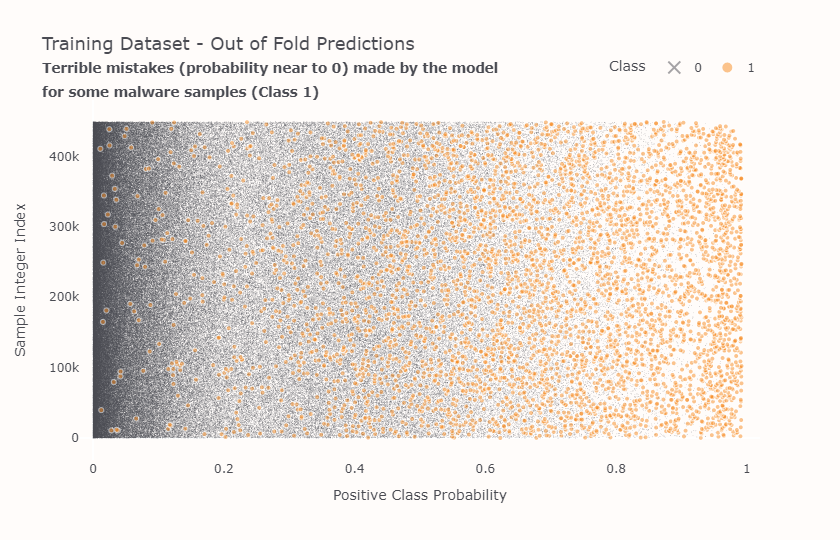

In [76]:
y_proba_frame = pd.DataFrame(
    {
        "Sample Integer Index": np.arange(0, len(y)),
        "Positive Class Probability": y_proba_bags.mean(axis=1),
        "Class": y.values.astype(str),
        "Size": np.where(y.values == 0, 0.01, 1.0),
    },
)

fig = px.scatter(
    y_proba_frame,
    x="Positive Class Probability",
    y="Sample Integer Index",
    symbol="Class",
    symbol_sequence=["x-thin-open", "circle"],
    color="Class",
    color_discrete_sequence=["#4A4B52", "#F78A1F"],
    category_orders={"Class": ("0", "1")},
    size="Size",
    size_max=5,
    opacity=0.5,
    height=540,
    width=840,
    title="Training Dataset - Out of Fold Predictions<br>"
    "<span style='font-size: 75%; font-weight: bold;'>"
    "Terrible mistakes (probability near to 0) made by the model<br>"
    "for some malware samples (Class 1)</span>",
)
fig.update_layout(
    legend=dict(
        orientation="h",
        yanchor="bottom",
        xanchor="right",
        y=1.05,
        x=1,
        title="Class",
        itemsizing="constant",
    ),
    xaxis_range=[-0.02, 1.02],
)
save_and_show_fig(fig, "out_of_fold_preds")


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #F78A1F;
">
    <b>CV Results</b>
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    <b>Well, the results are not impressive, actually these are poor. Model handles the malware cases in some way but makes a lot of mistakes during this by classifying benign domains as malware.</b> However, notice that I didn't tune the scheme at all. Here, I just take some undersampling factor and set primary hyperparameters of the Random Forest and KNN. However, these two models blend nicely because Random Forest handles the positive (malware) data quite well, and the KNN is much better in negative class predictions.
</p>

## <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">3.3</span> <span style='color: #F78A1F'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Test Subset Evaluation</span></b><a class="anchor" id="test_subset_evaluation"></a> [↑](#top)

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    Now suppose we are satisfied with the CV outcome (we're not) and want to evaluate the model on the test subset we've put down at the beginning of the notebook. Therefore, we train the model on the whole training subset and gather probabilities for the test subset. <b>If our CV scheme didn't have a data leakage then we should expect similar results, because test subset comes from the same distribution. Notice that we use the test subset now and only now.</b>
</p>

In [77]:
y_test_proba = np.zeros_like(y_test, dtype=np.float32)
pattern = "Bag: {:02d} - Seed: {:04d} - Training Samples Balance: {}"

for bag, seed in enumerate(seeds):
    negatives, positives = np.bincount(y)
    class_ratio = {0: int(undersampling_ratio * negatives), 1: positives}
    under_sampler = RandomUnderSampler(sampling_strategy=class_ratio, random_state=seed)
    X_res, y_res = under_sampler.fit_resample(X, y)
    print(pattern.format(bag + 1, seed, np.bincount(y_res)))

    model = make_pipeline(
        preprocess,
        VotingClassifier(
            [
                ("KNN", KNeighborsClassifier(weights="distance", n_neighbors=10)),
                (
                    "RF",
                    RandomForestClassifier(
                        random_state=seed,
                        min_samples_leaf=20,
                        class_weight=get_class_weights(y_res),
                    ),
                ),
            ],
            weights=(0.5, 0.5),
            voting="soft",
        ),
    ).fit(X_res, y_res)
    y_test_proba += model.predict_proba(X_test)[:, 1]

y_test_proba_avg = y_test_proba / n_bags


Bag: 01 - Seed: 0860 - Training Samples Balance: [13341  4499]
Bag: 02 - Seed: 1095 - Training Samples Balance: [13341  4499]
Bag: 03 - Seed: 1044 - Training Samples Balance: [13341  4499]
Bag: 04 - Seed: 0121 - Training Samples Balance: [13341  4499]
Bag: 05 - Seed: 0466 - Training Samples Balance: [13341  4499]


In [78]:
print_classification_stats(y_test, y_test_proba_avg)


F1:             0.12035
Recall:         0.79600
Specificity:    0.88432
Precision:      0.06510
ROC-AUC:        0.94121
Confusion Matrix:
 [[43698  5716]
 [  102   398]]


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #F78A1F;
">
    <b>Test Dataset Results</b>
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    <b>And we got very similar results for test dataset. Obviously these are also low, but small differences say that there is no data leakage and approach is mostly probably valid. Therefore, if we feed the model with unknown data from the same distribution, it should obtain same results as in the CV scheme.</b> Now let's visualize all metrics for test dataset.
</p>

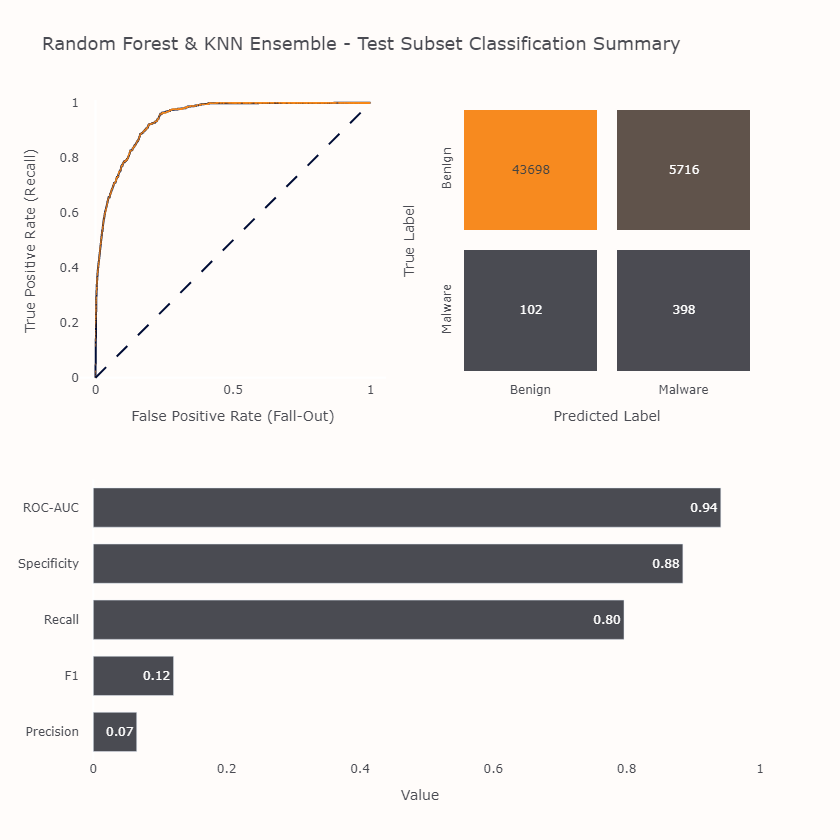

In [79]:
y_test_pred = np.where(y_test_proba_avg > 0.5, 1, 0)
scores = {}

scores["Precision"] = precision_score(y_test, y_test_pred)
scores["Recall"] = recall_score(y_test, y_test_pred)
scores["Specificity"] = recall_score(y_test, y_test_pred, pos_label=0)
scores["F1"] = f1_score(y_test, y_test_pred)
scores["ROC-AUC"] = roc_auc_score(y_test, y_test_proba_avg)
metrics_for_bar = pd.DataFrame(scores, index=["Value"]).T

scores["ConfusionMatrix"] = confusion_matrix(y_test, y_test_pred)
scores["FPR-TPR-Threshold"] = roc_curve(y_test, y_test_proba_avg)


fig = make_subplots(rows=2, cols=2, specs=[[{}, {}], [{"colspan": 2}, None]])

fig.add_scatter(
    x=scores["FPR-TPR-Threshold"][0],
    y=scores["FPR-TPR-Threshold"][1],
    name="",
    mode="markers+lines",
    line_color="#010D36",
    marker=dict(size=1.25, color="#F78A1F", opacity=0.4, symbol="x"),
    showlegend=False,
    row=1,
    col=1,
)
fig.add_scatter(
    x=[0, 1],
    y=[0, 1],
    name="",
    mode="lines",
    line=dict(dash="longdash", color="#010D36"),
    showlegend=False,
    row=1,
    col=1,
)
fig.update_yaxes(
    scaleanchor="x",
    scaleratio=1,
    range=(-0.01, 1.01),
    title="True Positive Rate (Recall)",
    row=1,
    col=1,
)
fig.update_xaxes(
    scaleanchor="y",
    scaleratio=1,
    range=(-0.01, 1.01),
    title="False Positive Rate (Fall-Out)",
    row=1,
    col=1,
)

fig.add_heatmap(
    z=scores["ConfusionMatrix"],
    x=["Benign", "Malware"],
    y=["Benign", "Malware"],
    name="",
    text=scores["ConfusionMatrix"],
    texttemplate="%{text}",
    xgap=20,
    ygap=20,
    showscale=False,
    colorscale=[[0.0, "#4A4B52"], [1.0, "#F78A1F"]],
    row=1,
    col=2,
)
fig.update_yaxes(title="True Label", autorange="reversed", tickangle=-90, row=1, col=2)
fig.update_xaxes(title="Predicted Label", row=1, col=2)

fig.add_bar(
    x=metrics_for_bar.Value,
    y=metrics_for_bar.index,
    name="",
    texttemplate="%{x:.2f}",
    hovertemplate="%{y}<br>%{x:.5f}",
    marker_color="#4A4B52",
    showlegend=False,
    orientation="h",
    width=0.7,
    row=2,
    col=1,
)
fig.update_yaxes(categoryorder="total ascending", row=2, col=1)
fig.update_xaxes(title="Value", range=(-0.02, 1.0), row=2, col=1)

fig.update_layout(
    title="Random Forest & KNN Ensemble - Test Subset Classification Summary",
    height=840,
    width=840,
)
save_and_show_fig(fig, "classification_summary_for_test")


# <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">4</span> <span style='color: #F78A1F'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Summary</span></b><a class="anchor" id="summary"></a> [↑](#top)

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #F78A1F;
">
    <b>Some Words at the End</b>
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    Let's summarize all the work depicted in this notebook.
</p>

<ul style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    <li>This is a binary classification task where the dataset is highly imbalanced (ratio of 99:1), which resembles fraud detection problems. Therefore, we put down a test subset at the beginning of the notebook, splitting it in a stratified fashion.</li>
    <li>We presented a quick overview of the dataset and chose 17 features, which were used to predict whether the sample is associated with a benign or malware domain. Subsequently, we prepared a preprocessing pipeline, and thereby, we could feed the classifier with raw data.</li>
    <li>Since the dataset is imbalanced, we chose metrics like Recall, Precision, F1, Specificity and ROC-AUC for the model evaluation. We talked a little about these metrics and got to the CV scheme.</li>
    <li>We decided to solve the high imbalance by undersampling strategy in connection with attaching higher weights to positive class (malware). Therefore, we trained several models and got mean probabilities of positive class.</li>
    <li>The final step was to evaluate the model on the test subset we've put down at the beginning. We observed very similar results for this subset, so it suggests that there wasn't any data leakage in the CV scheme. Thus, the presented model should obtain same results for new data.</li>
    <li>Obtained results are poor, but we haven't analysed the data for so long to draw better conclusions. Moreover, we assumed the worst situation in test dataset.</li>
    <li>In order to get better results, we should analyse the data more profoundly and provide better cleaning. Moreover, perhaps the remaining features are also informative and may be helpful. From the perspective of undersampling and classifiers itself, there is an obvious field to tuning hyperparameters, undersampling factors and class weights.</li>
    <li>Question. Do we really want to feed models with domains created before 1995, where malware domains probably didn't exist? If we ignore this data, we get a more balanced dataset and models will have a simpler task.</li>
    <li>Question. How low precision of the model do we allow?</li>
    <li>Question. What probability threshold do we allow to classify observation as malware? Now it's > 50%.</li>
    <li>Further analysis may concern correlation matrix, hierarchical clustering, better fit to the normal distribution with probability plots, feature selection with mutual information, shap library or permutation tests. Also, including random features may be interesting to see whether it counts for models more than dataset features. The technique we didn't discuss here is the oversampling of the minority class. Perhaps this would give us better results? A completely different approach for this problem may be to observe how the dataset looks in 2D or 3D. Whether samples are separable there or not. If samples are not separable, the oversampling with SMOTE probably won't help because it will introduce not representative samples.</li>
</ul>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    Thank you if you read this.
</p>